 # H&M 재구매 예측 모델링



 ## 목표

 - **첫 구매 시점 정보만** 사용하여 재구매 예측
 - 데이터 누수 문제 해결
 - 실전 배포 가능한 모델 개발

### 데이터 누수(Data Leakage) 문제 해결

#### 현재 문제

##### 타겟 정의
```python
is_repeat = (purchase_count >= 2)
학습데이터에 purchase_count 등 재구매해야 알 수 있는 정보 넣으면 안됨
```

##### 누수 특성 (즉시 제거 필요)

1. 타겟과 동일한 정보
```python
- purchase_count    # 타겟 정의에 직접 사용
- frequency         # purchase_count와 동일
```

2. 재구매 후에만 알 수 있는 정보
```python
- customer_lifetime         # 마지막 구매일 필요
- total_purchase/monetary   # 총 구매액 (구매 횟수에 비례)
- unique_products          # 총 제품 수
- std_purchase            # 여러 구매 필요
- avg_days_between_purchases  # 누수 특성 조합
- purchase_diversity         # 누수 특성 조합
```

##### 문제 핵심
- 문제: 전체 구매 이력으로 "이미 재구매했는지" 예측 (답을 보고 푸는 상황)
- 해결: 첫 구매 시점 정보로 "미래에 재구매할지" 예측 (실전 활용)

---

#### ✅ 해결 방법: 첫 구매 시점 특성만 사용

##### 사용 가능한 특성

1. 첫 구매 거래 정보
```python
- first_purchase_price       # 첫 구매 금액
- first_product_category     # 첫 제품 카테고리
- first_product_type         # 첫 제품 타입
- first_colour_group         # 첫 제품 색상
- first_purchase_channel     # 첫 구매 채널 (온라인/오프라인)
- first_purchase_weekday     # 첫 구매 요일
- first_purchase_month       # 첫 구매 월
- first_purchase_is_weekend  # 주말 구매 여부
```

2. 고객 정보 (첫 구매 당시)
```python
- age                        # 연령
- age_group                  # 연령대
- club_member_status         # 회원 상태
- fashion_news_frequency     # 뉴스레터 수신 빈도
- active                     # Active 고객 여부
- fn                        # Fashion News 수신 여부
```

3. 외부 집계 정보 (첫 구매 이전 데이터 기반)
```python
- product_popularity_score      # 해당 제품의 인기도
- category_repurchase_rate      # 카테고리 평균 재구매율
- age_group_repurchase_rate     # 연령대 평균 재구매율
- channel_repurchase_rate       # 채널 평균 재구매율
- product_avg_price            # 제품 평균 가격
```

---

#### 타겟 재정의 (선택사항)

타겟 재정의는 **데이터 누수 해결과 무관**하며, **비즈니스 가치 향상을 위한 추가 옵션**입니다.

##### 옵션 A: 기존 타겟 유지
```python
is_repeat = (purchase_count >= 2)  # "언젠가 재구매"
```
- 구현 간단
- 재구매 시점 불명확 (1주 후? 1년 후?)

##### 옵션 B: 타겟 재정의 (고려)  <-더 바람직! (근데 이번 실습에서는 옵션 A로 활용)

```python
is_repeat_90d = (second_purchase_date - first_purchase_date <= 90일)
```
- 마케팅 타이밍 명확 (90일 후 프로모션)
- 시간 기반 검증 가능
- 비즈니스 실용성 높음

**특성은 동일하게 사용 가능**

---

**핵심**: 첫 구매 시점에 알 수 있는 정보만 사용하면 데이터 누수 해결!

 ---

 # 0️⃣ 환경 설정

In [1]:
# 라이브러리 Import
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

np.random.seed(42)

print("="*60)
print("라이브러리 로드 완료!")
print("="*60)

라이브러리 로드 완료!


 ---

 # 1️⃣ 데이터 로드

In [ ]:
print("\n" + "="*60)
print("전처리 완료 데이터 로드")
print("="*60)

# 데이터 로드 (전처리한 데이터만 불러와)
df_full = pd.read_csv('./processed_data/df_full.csv')
customer_stats = pd.read_csv('./processed_data/customer_stats.csv')
product_stats = pd.read_csv('./processed_data/product_stats.csv')

# 날짜 컬럼 변환
df_full['t_dat'] = pd.to_datetime(df_full['t_dat'])
customer_stats['first_purchase'] = pd.to_datetime(customer_stats['first_purchase'])
customer_stats['last_purchase'] = pd.to_datetime(customer_stats['last_purchase'])

print(f"✅ df_full: {df_full.shape}")
print(f"✅ customer_stats: {customer_stats.shape}")
print(f"✅ product_stats: {product_stats.shape}")

print(f"\n타겟 변수 분포:")
print(customer_stats['is_repeat'].value_counts())
print(f"재구매율: {customer_stats['is_repeat'].mean()*100:.2f}%")


전처리 완료 데이터 로드
✅ df_full: (1040101, 47)
✅ customer_stats: (458235, 10)
✅ product_stats: (51279, 5)

타겟 변수 분포:
is_repeat
0    230040
1    228195
Name: count, dtype: int64
재구매율: 49.80%


 ---

 # 2️⃣ 데이터 누수 해결: 첫 구매 시점 특성 추출

In [3]:
print("\n" + "="*60)
print("첫 구매 시점 특성 추출 (데이터 누수 제거)")
print("="*60)

# 고객별 첫 구매 정보 추출
first_purchase_info = df_full.sort_values('t_dat').groupby('customer_id').first().reset_index()

# 첫 구매 거래 정보
first_purchase_features = first_purchase_info[[
    'customer_id',
    'price',                    # 첫 구매 금액
    'sales_channel_id',         # 첫 구매 채널
    'dayofweek',                # 첫 구매 요일
    'month',                    # 첫 구매 월
    'quarter',                  # 첫 구매 분기
    'is_weekend',               # 주말 구매 여부
]].rename(columns={
    'price': 'first_purchase_price',
    'sales_channel_id': 'first_channel',
    'dayofweek': 'first_dayofweek',
    'month': 'first_month',
    'quarter': 'first_quarter',
    'is_weekend': 'first_is_weekend'
})

# 첫 구매 제품 정보
first_product_features = first_purchase_info[[
    'customer_id',
    'product_type_name',
    'product_group_name',
    'colour_group_name',
    'department_name',
    'section_name',
    'garment_group_name'
]].rename(columns={
    'product_type_name': 'first_product_type',
    'product_group_name': 'first_product_group',
    'colour_group_name': 'first_colour',
    'department_name': 'first_department',
    'section_name': 'first_section',
    'garment_group_name': 'first_garment'
})

# 첫 구매 당시 고객 정보
first_customer_features = first_purchase_info[[
    'customer_id',
    'age',
    'active',
    'fn',
    'club_member_status',
    'fashion_news_frequency'
]]

print("- 첫 구매 거래 특성 추출 완료")
print("- 첫 구매 제품 특성 추출 완료")
print("- 첫 구매 당시 고객 특성 추출 완료")



첫 구매 시점 특성 추출 (데이터 누수 제거)
- 첫 구매 거래 특성 추출 완료
- 첫 구매 제품 특성 추출 완료
- 첫 구매 당시 고객 특성 추출 완료


 ### 외부 집계 정보 계산 (첫 구매 이전 데이터 기반)

In [4]:
print("\n" + "="*60)
print("외부 집계 정보 계산 (과거 데이터 기반)")
print("="*60)

# 제품 수준 집계
product_agg = product_stats[[
    'article_id',
    'popularity_score',
    'avg_price'
]].rename(columns={
    'popularity_score': 'product_popularity',
    'avg_price': 'product_avg_price'
})

# 첫 구매에 해당하는 제품 정보 병합
first_purchase_with_product = first_purchase_info[['customer_id', 'article_id']].merge(
    product_agg,
    on='article_id',
    how='left'
)

# 카테고리별 재구매율 (전체 고객 기준)
category_repurchase = df_full.groupby('department_name').apply(
    lambda x: (x.groupby('customer_id').size() >= 2).mean()
).reset_index()
category_repurchase.columns = ['department_name', 'category_repurchase_rate']

# 연령대별 재구매율
age_group_repurchase = df_full.merge(
    customer_stats[['customer_id', 'is_repeat']],
    on='customer_id'
).groupby('age_group')['is_repeat'].mean().reset_index()
age_group_repurchase.columns = ['age_group', 'age_group_repurchase_rate']

# 채널별 재구매율
channel_repurchase = df_full.merge(
    customer_stats[['customer_id', 'is_repeat']],
    on='customer_id'
).groupby('sales_channel_id')['is_repeat'].mean().reset_index()
channel_repurchase.columns = ['sales_channel_id', 'channel_repurchase_rate']

print("- 제품 인기도 및 평균 가격 계산 완료")
print("- 카테고리별 재구매율 계산 완료")
print("- 연령대별 재구매율 계산 완료")
print("- 채널별 재구매율 계산 완료")



외부 집계 정보 계산 (과거 데이터 기반)
- 제품 인기도 및 평균 가격 계산 완료
- 카테고리별 재구매율 계산 완료
- 연령대별 재구매율 계산 완료
- 채널별 재구매율 계산 완료


 ---

 # 3️⃣ 모델링 데이터 생성

In [5]:
print("\n" + "="*60)
print("모델링 데이터 생성")
print("="*60)

# 1. 기본 특성 병합
modeling_df = first_purchase_features.copy()
modeling_df = modeling_df.merge(first_product_features, on='customer_id', how='left')
modeling_df = modeling_df.merge(first_customer_features, on='customer_id', how='left')

# 2. 외부 집계 정보 병합
modeling_df = modeling_df.merge(first_purchase_with_product[['customer_id', 'product_popularity', 'product_avg_price']], 
                                  on='customer_id', how='left')

# 카테고리 재구매율 병합
modeling_df = modeling_df.merge(category_repurchase, 
                                  left_on='first_department', 
                                  right_on='department_name', 
                                  how='left').drop('department_name', axis=1)

# 연령대 생성 후 재구매율 병합
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['10대', '20대', '30대', '40대', '50대', '60대이상']
modeling_df['age_group'] = pd.cut(modeling_df['age'], bins=bins, labels=labels, right=False)

modeling_df = modeling_df.merge(age_group_repurchase, on='age_group', how='left')

# 채널 재구매율 병합
modeling_df = modeling_df.merge(channel_repurchase, 
                                  left_on='first_channel', 
                                  right_on='sales_channel_id', 
                                  how='left').drop('sales_channel_id', axis=1)

# 3. 타겟 변수 병합
modeling_df = modeling_df.merge(customer_stats[['customer_id', 'is_repeat']], 
                                  on='customer_id', how='left')

print(f"✅ 모델링 데이터 생성 완료: {modeling_df.shape}")
print(f"\n결측치 확인:")
print(modeling_df.isnull().sum()[modeling_df.isnull().sum() > 0])


모델링 데이터 생성
✅ 모델링 데이터 생성 완료: (458235, 25)

결측치 확인:
club_member_status    104675
dtype: int64


 ---

 # 4️⃣ 데이터 전처리

In [ ]:
print("\n" + "="*60)
print("데이터 전처리")
print("="*60)

# 결측치 처리
print("\n[결측치 처리]")
for col in modeling_df.columns:
    if modeling_df[col].isnull().sum() > 0:
        if modeling_df[col].dtype in ['float64', 'int64']:
            modeling_df[col].fillna(modeling_df[col].median(), inplace=True)
            print(f"  • {col}: 중앙값으로 대체")
        else:
            modeling_df[col].fillna('UNKNOWN', inplace=True)
            print(f"  • {col}: 'UNKNOWN'으로 대체")

# 특성 선택
exclude_cols = ['customer_id', 'is_repeat', 'age_group'] # 제외할 컬럼들
feature_cols = [col for col in modeling_df.columns if col not in exclude_cols]

print(f"\n[선택된 특성 ({len(feature_cols)}개)]")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# X, y 분리
X = modeling_df[feature_cols].copy()
y = modeling_df['is_repeat'].copy()

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"재구매율: {y.mean()*100:.2f}%")



데이터 전처리

[결측치 처리]
  • club_member_status: 'UNKNOWN'으로 대체

[선택된 특성 (22개)]
  1. first_purchase_price
  2. first_channel
  3. first_dayofweek
  4. first_month
  5. first_quarter
  6. first_is_weekend
  7. first_product_type
  8. first_product_group
  9. first_colour
  10. first_department
  11. first_section
  12. first_garment
  13. age
  14. active
  15. fn
  16. club_member_status
  17. fashion_news_frequency
  18. product_popularity
  19. product_avg_price
  20. category_repurchase_rate
  21. age_group_repurchase_rate
  22. channel_repurchase_rate

X shape: (458235, 22)
y shape: (458235,)
재구매율: 49.80%


In [7]:
# 특성 데이터 확인
X.head()

,first_purchase_price,first_channel,first_dayofweek,first_month,first_quarter,first_is_weekend,first_product_type,first_product_group,first_colour,first_department,first_section,first_garment,age,active,fn,club_member_status,fashion_news_frequency,product_popularity,product_avg_price,category_repurchase_rate,age_group_repurchase_rate,channel_repurchase_rate
0,0.050831,2,5,5,2,1,Blazer,Garment Upper body,Black,Suit,Womens Tailoring,Dressed,49.0,0.0,0.0,ACTIVE,NONE,0.405269,0.048391,0.038156,0.793646,0.807204
1,0.025407,2,1,5,2,0,Bikini top,Swimwear,Black,Swimwear,"Womens Swimwear, beachwear",Swimwear,25.0,0.0,0.0,ACTIVE,NONE,0.178812,0.024691,0.208476,0.780863,0.807204
2,0.042356,2,2,10,4,0,Leggings/Tights,Garment Lower body,Black,Ladies Sport Bottoms,Ladies H&M Sport,Jersey Fancy,32.0,0.0,0.0,UNKNOWN,NONE,0.166480,0.040423,0.065557,0.788722,0.807204
3,0.025407,2,1,6,2,0,Bikini top,Swimwear,Dark Green,Swimwear,"Womens Swimwear, beachwear",Swimwear,20.0,0.0,0.0,ACTIVE,NONE,0.045404,0.024349,0.208476,0.780863,0.807204
4,0.015237,2,6,1,1,1,Pyjama bottom,Nightwear,Black,Nightwear,"Womens Nightwear, Socks & Tigh","Under-, Nightwear",32.0,1.0,1.0,ACTIVE,Regularly,0.004484,0.011729,0.056170,0.788722,0.807204


 ### 범주형 변수 인코딩

In [8]:
print("\n" + "="*60)
print("범주형 변수 인코딩")
print("="*60)

# 범주형 변수 식별
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"범주형 변수 ({len(categorical_cols)}개):")
for col in categorical_cols:
    print(f"  • {col}: {X[col].nunique()}개 카테고리")

# Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\n✅ Label Encoding 완료")


범주형 변수 인코딩
범주형 변수 (8개):
  • first_product_type: 112개 카테고리
  • first_product_group: 16개 카테고리
  • first_colour: 50개 카테고리
  • first_department: 236개 카테고리
  • first_section: 56개 카테고리
  • first_garment: 21개 카테고리
  • club_member_status: 4개 카테고리
  • fashion_news_frequency: 3개 카테고리

✅ Label Encoding 완료


 ---

 # 5️⃣ Train/Test 분할

In [ ]:
print("\n" + "="*60)
print("Train/Test 데이터 분할")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\n[Train set 타겟 분포]")
print(y_train.value_counts())
print(f"재구매율: {y_train.mean()*100:.2f}%")

print(f"\n[Test set 타겟 분포]")
print(y_test.value_counts())
print(f"재구매율: {y_test.mean()*100:.2f}%")


Train/Test 데이터 분할
Train set: (366588, 22)
Test set: (91647, 22)

[Train set 타겟 분포]
is_repeat
0    184032
1    182556
Name: count, dtype: int64
재구매율: 49.80%

[Test set 타겟 분포]
is_repeat
0    46008
1    45639
Name: count, dtype: int64
재구매율: 49.80%


 ### 스케일링

In [10]:
print("\n" + "="*60)
print("특성 스케일링")
print("="*60)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame으로 변환
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ StandardScaler 적용 완료")


특성 스케일링
✅ StandardScaler 적용 완료


 ---

 # 6️⃣ 모델 학습

 ## 6.1 Logistic Regression


모델 1: Logistic Regression

[성능 지표]
Accuracy:  0.6448
Precision: 0.6359
Recall:    0.6711
F1-Score:  0.6530
ROC-AUC:   0.6963


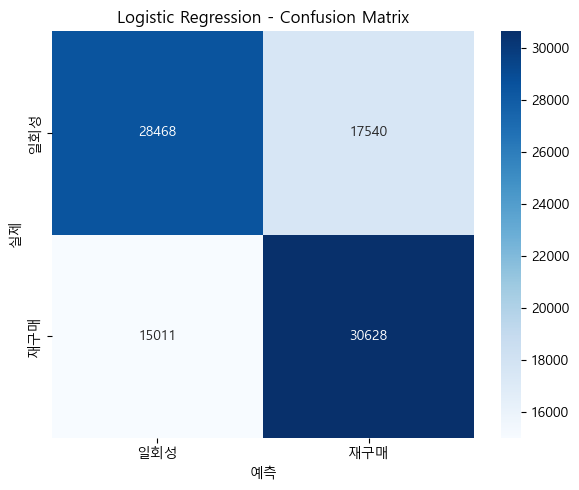

In [11]:
print("\n" + "="*60)
print("모델 1: Logistic Regression")
print("="*60)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# 평가
print(f"\n[성능 지표]")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['일회성', '재구매'], 
            yticklabels=['일회성', '재구매'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('실제')
plt.xlabel('예측')
plt.tight_layout()
plt.show()

 ## 6.2 Random Forest


모델 2: Random Forest

[성능 지표]
Accuracy:  0.6243
Precision: 0.6216
Recall:    0.6279
F1-Score:  0.6247
ROC-AUC:   0.6704


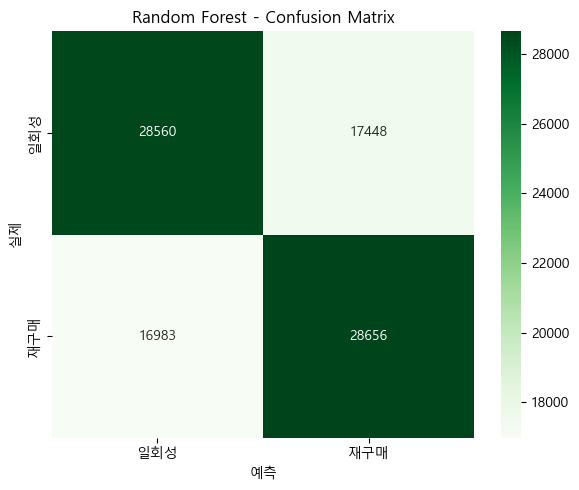

In [12]:
print("\n" + "="*60)
print("모델 2: Random Forest")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# 평가
print(f"\n[성능 지표]")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['일회성', '재구매'], 
            yticklabels=['일회성', '재구매'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('실제')
plt.xlabel('예측')
plt.tight_layout()
plt.show()


 ## 6.3 XGBoost


모델 3: XGBoost

[성능 지표]
Accuracy:  0.6548
Precision: 0.6403
Recall:    0.7002
F1-Score:  0.6689
ROC-AUC:   0.7106


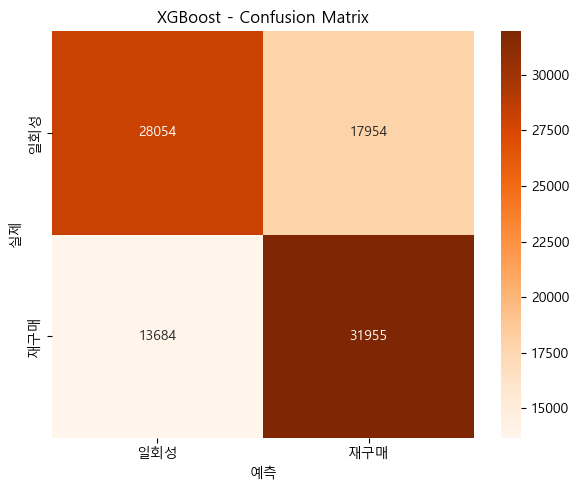

In [13]:
print("\n" + "="*60)
print("모델 3: XGBoost")
print("="*60)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# 평가
print(f"\n[성능 지표]")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['일회성', '재구매'], 
            yticklabels=['일회성', '재구매'])
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('실제')
plt.xlabel('예측')
plt.tight_layout()
plt.show()

 ---

 # 7️⃣ 모델 비교 및 최적화


모델 성능 비교

[모델별 성능 지표]


,모델,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.6448,0.6359,0.6711,0.6530,0.6963
1,Random Forest,0.6243,0.6216,0.6279,0.6247,0.6704
2,XGBoost,0.6548,0.6403,0.7002,0.6689,0.7106


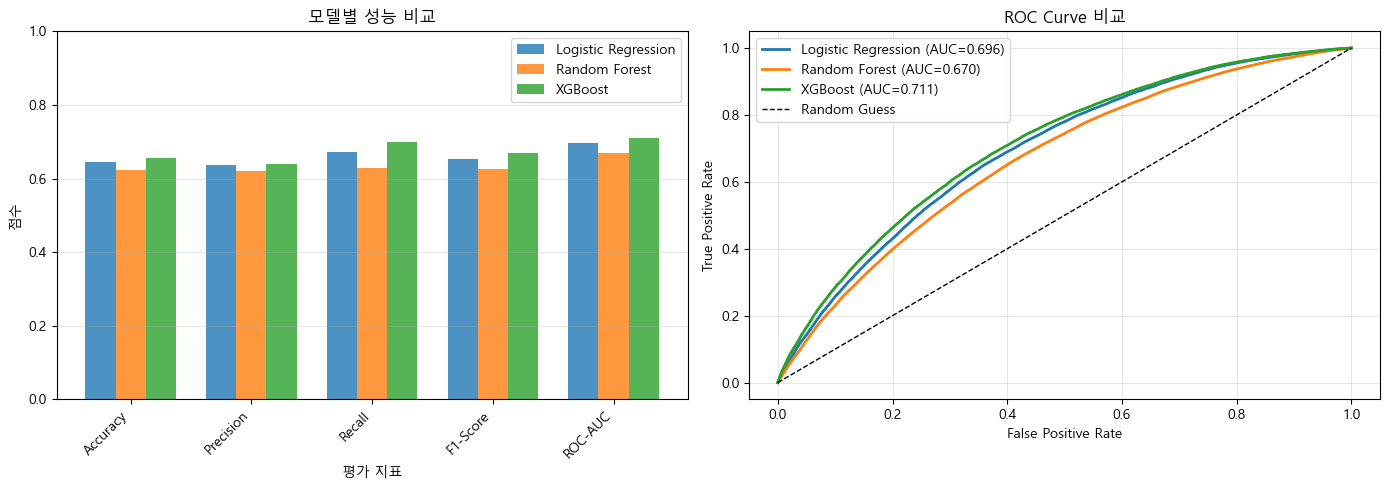


🏆 최고 성능 모델: XGBoost
   F1-Score: 0.6689


In [14]:
print("\n" + "="*60)
print("모델 성능 비교")
print("="*60)

results_df = pd.DataFrame({
    '모델': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr),
                 accuracy_score(y_test, y_pred_rf),
                 accuracy_score(y_test, y_pred_xgb)],
    'Precision': [precision_score(y_test, y_pred_lr),
                  precision_score(y_test, y_pred_rf),
                  precision_score(y_test, y_pred_xgb)],
    'Recall': [recall_score(y_test, y_pred_lr),
               recall_score(y_test, y_pred_rf),
               recall_score(y_test, y_pred_xgb)],
    'F1-Score': [f1_score(y_test, y_pred_lr),
                 f1_score(y_test, y_pred_rf),
                 f1_score(y_test, y_pred_xgb)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred_proba_lr),
                roc_auc_score(y_test, y_pred_proba_rf),
                roc_auc_score(y_test, y_pred_proba_xgb)]
})

print("\n[모델별 성능 지표]")
display(results_df.round(4))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 지표별 비교
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, results_df.iloc[0, 1:], width, label='Logistic Regression', alpha=0.8)
axes[0].bar(x, results_df.iloc[1, 1:], width, label='Random Forest', alpha=0.8)
axes[0].bar(x + width, results_df.iloc[2, 1:], width, label='XGBoost', alpha=0.8)

axes[0].set_xlabel('평가 지표')
axes[0].set_ylabel('점수')
axes[0].set_title('모델별 성능 비교')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})', linewidth=2)
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)
axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)

axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve 비교')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_model_idx = results_df['F1-Score'].idxmax()
print(f"\n🏆 최고 성능 모델: {results_df.loc[best_model_idx, '모델']}")
print(f"   F1-Score: {results_df.loc[best_model_idx, 'F1-Score']:.4f}")


 ## 하이퍼파라미터 튜닝

In [15]:
print("\n" + "="*60)
print("하이퍼파라미터 튜닝 - XGBoost")
print("="*60)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

print("탐색할 파라미터:")
for key, values in param_grid.items():
    print(f"  • {key}: {values}")

grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\n그리드 서치 시작...")
grid_search.fit(X_train_scaled, y_train)

print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최적 F1-Score (CV): {grid_search.best_score_:.4f}")

# 최적 모델 평가
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_scaled)
y_pred_proba_best = best_xgb.predict_proba(X_test_scaled)[:, 1]

print(f"\n[최적화된 XGBoost 성능]")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_best):.4f}")

print("\n[Classification Report]")
print(classification_report(y_test, y_pred_best, target_names=['일회성', '재구매']))



하이퍼파라미터 튜닝 - XGBoost
탐색할 파라미터:
  • n_estimators: [100, 200]
  • max_depth: [3, 5, 7]
  • learning_rate: [0.01, 0.1]
  • subsample: [0.8, 1.0]

그리드 서치 시작...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

최적 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
최적 F1-Score (CV): 0.6690

[최적화된 XGBoost 성능]
Accuracy:  0.6540
Precision: 0.6392
Recall:    0.7005
F1-Score:  0.6684
ROC-AUC:   0.7098

[Classification Report]
              precision    recall  f1-score   support

         일회성       0.67      0.61      0.64     46008
         재구매       0.64      0.70      0.67     45639

    accuracy                           0.65     91647
   macro avg       0.66      0.65      0.65     91647
weighted avg       0.66      0.65      0.65     91647



# 8️⃣ Feature Importance 분석


Feature Importance 분석

[상위 15개 중요 특성]


,특성,중요도
3,first_month,0.540403
1,first_channel,0.088705
15,club_member_status,0.086853
20,age_group_repurchase_rate,0.065398
13,active,0.052711
16,fashion_news_frequency,0.035426
12,age,0.027856
0,first_purchase_price,0.016300
10,first_section,0.015618
7,first_product_group,0.011799


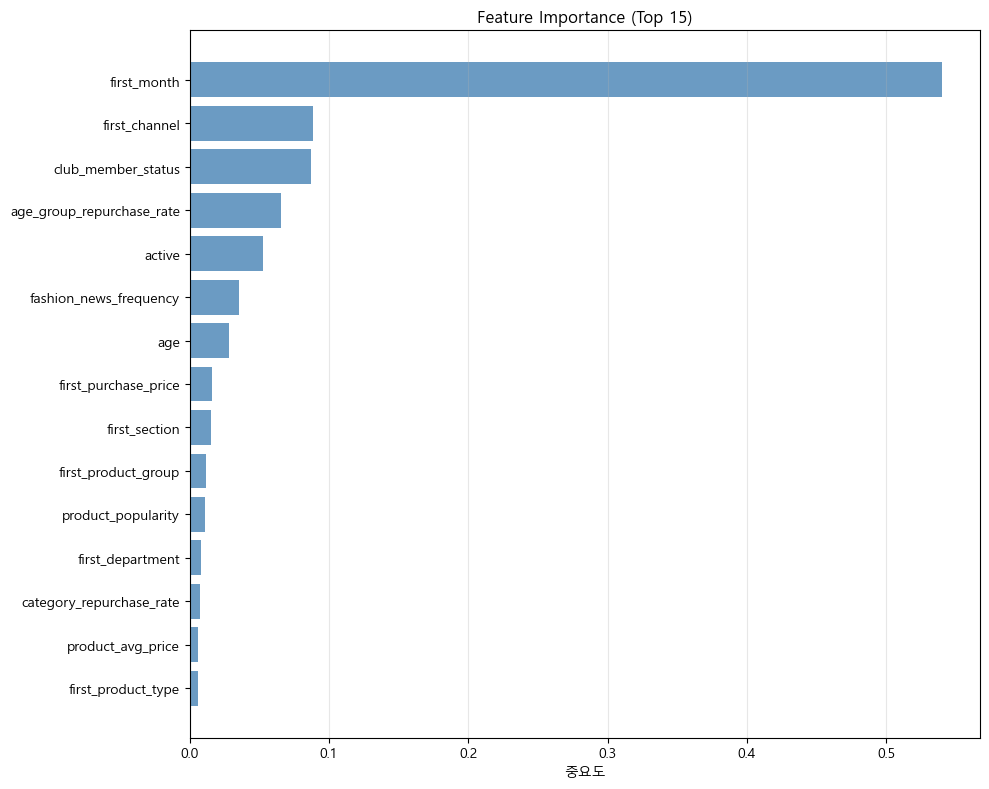

In [16]:
print("\n" + "="*60)
print("Feature Importance 분석")
print("="*60)

feature_importance = best_xgb.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    '특성': feature_names,
    '중요도': feature_importance
}).sort_values('중요도', ascending=False)

print("\n[상위 15개 중요 특성]")
display(importance_df.head(15))

# 시각화
plt.figure(figsize=(10, 8))
top_n = 15
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['중요도'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['특성'])
plt.xlabel('중요도')
plt.title(f'Feature Importance (Top {top_n})')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## SHAP을 활용한 Feature Importance 분석

### SHAP (SHapley Additive exPlanations)

**원리:**
- "이 특성이 없었다면 예측값이 얼마나 달라졌을까?"를 정량화
- 모든 특성 조합을 고려하여 공정하게 기여도를 분배

**SHAP기반 개별 예측 원리:**
```plain
개별 예측값 = 기준값(평균) + SHAP(특성1) + SHAP(특성2) + ... + SHAP(특성n)

예시: 고객 A의 재구매 확률 78%
  = 76% (전체 평균)
  + 5% (first_month=3월)
  - 4% (age=55세)
  + 3% (first_channel=매장)
  - 2% (club_member=PRE-CREATE)
  ...
```

**Feature Importance vs SHAP:**
- **트리기반 Feature Importance**: "분할 시 불순도를 얼마나 감소시켰는가?" (모델 내부)
- **SHAP**: "최종 예측값을 얼마나 변화시켰는가?" (예측 결과)

**장점:**
- 트리, 선형, 딥러닝 등 모든 ML 모델에서 특성 중요도 분석 가능
- 방향성: 양수(재구매↑) / 음수(재구매↓) 구분 가능
- 개별 예측 설명: 특정 고객이 왜 그렇게 예측되었는지 분석 가능

In [17]:
import shap
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("SHAP 분석 시작")
print("="*60)

# SHAP Explainer 생성
print("\nSHAP Explainer 생성 중...")
explainer = shap.TreeExplainer(best_xgb)

# SHAP values 계산 (샘플링으로 속도 향상)
sample_size = min(1000, len(X_test_scaled))
X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)

print(f"SHAP values 계산 중... (샘플 크기: {sample_size})")
shap_values = explainer.shap_values(X_test_sample)

print("SHAP 분석 완료!\n")


SHAP 분석 시작

SHAP Explainer 생성 중...
SHAP values 계산 중... (샘플 크기: 1000)
SHAP 분석 완료!



SHAP Summary Plot - 전체 특성 중요도


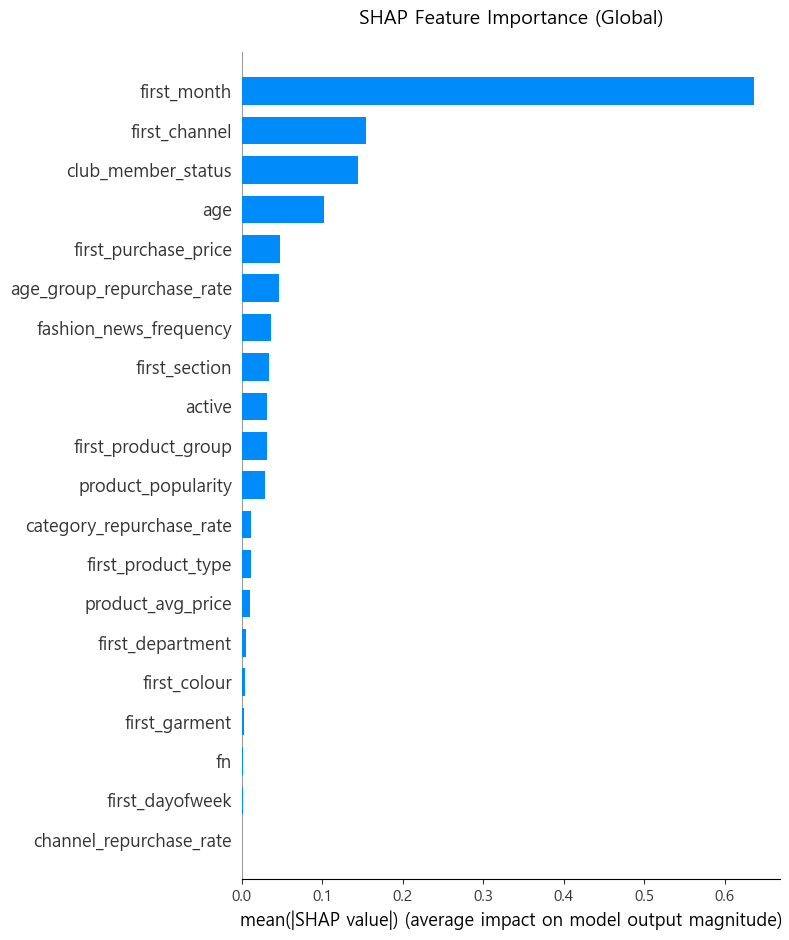

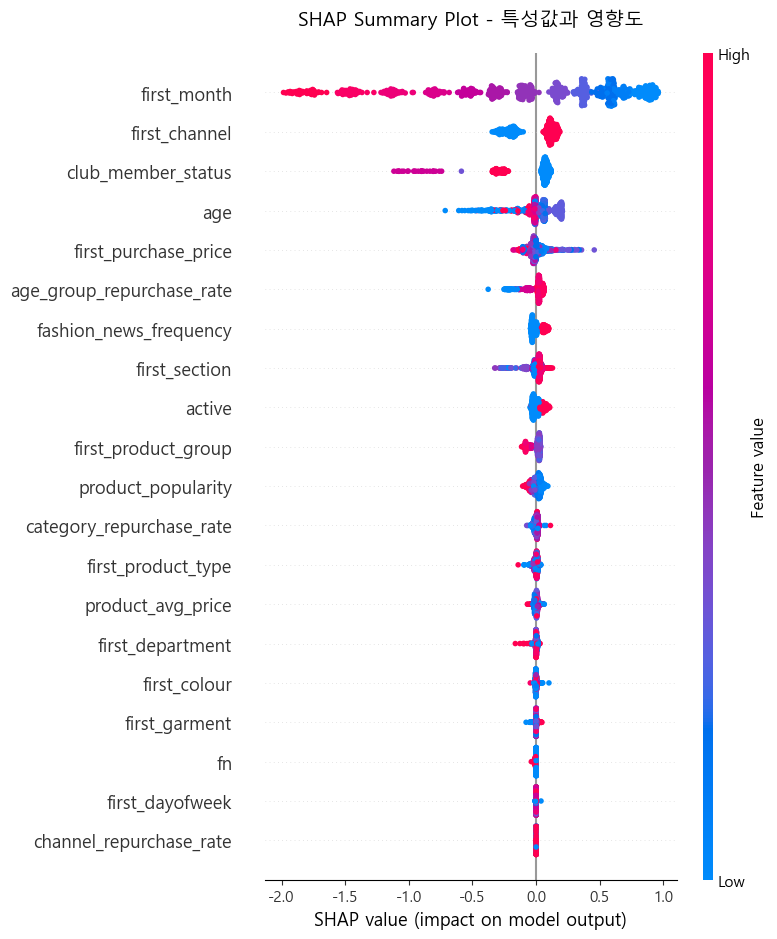


📊 해석 가이드:
- 왼쪽 그래프: 각 특성의 평균 절대 SHAP 값 (전역적 중요도)
- 오른쪽 그래프: 
  * 각 점은 하나의 예측을 나타냄
  * 색상: 특성 값 (빨강=높음, 파랑=낮음)
  * 위치: SHAP 값
    - 왼쪽(-): 재구매 가능성 감소
    - 오른쪽(+): 재구매 가능성 증가



In [18]:
print("="*60)
print("SHAP Summary Plot - 전체 특성 중요도")
print("="*60)

# Summary Plot (Bar)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Global)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Summary Plot (Bee swarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Summary Plot - 특성값과 영향도', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("""
📊 해석 가이드:
- 왼쪽 그래프: 각 특성의 평균 절대 SHAP 값 (전역적 중요도)
- 오른쪽 그래프: 
  * 각 점은 하나의 예측을 나타냄
  * 색상: 특성 값 (빨강=높음, 파랑=낮음)
  * 위치: SHAP 값
    - 왼쪽(-): 재구매 가능성 감소
    - 오른쪽(+): 재구매 가능성 증가
""")

### **Chart 1: SHAP Feature Importance (Global) - 전역 중요도**

#### Top 5 중요 특성

1. **first_month (첫 구매 월)** - 압도적 1위 (~0.65)
   - 계절성과 시기가 재구매에 결정적 영향
   
2. **first_channel (첫 구매 채널)** - 2위 (~0.15)
   - 온라인 vs 매장 구매가 재구매 행동 예측에 중요

3. **club_member_status (회원 상태)** - 3위 (~0.13)
   - 회원 등급이 재구매 가능성을 나타내는 강력한 지표

4. **age (나이)** - 4위 (~0.10)
   - 연령대별로 재구매 패턴이 다름

5. **first_purchase_price (첫 구매 금액)** - 5위 (~0.05)
   - 첫 구매 가격대가 재구매 의사에 영향

#### 영향력 낮은 특성
- channel_repurchase_rate, first_dayofweek, first_garment 등은 거의 영향 없음

---

### **Chart 2: SHAP Summary Plot - 특성값과 영향도**

#### 1. **first_month (첫 구매 월)**
- **빨간 점(높은 월번호)**: 왼쪽으로 퍼짐 → **하반기 구매 고객이 재구매 가능성 낮음**
- **파란 점(낮은 월번호)**: 오른쪽으로 퍼짐 → **상반기 구매 고객은 재구매 가능성 높음**
- **인사이트**: 1-6월 신규 고객은 재구매 확률 높음 
        

#### 2. **first_channel (구매 채널)**
- **파란 점(channel=1, 온라인)**: 왼쪽으로 퍼짐 → **온라인 구매 고객은 재구매 가능성 낮음**
- **빨간 점(channel=2, 매장)**: 오른쪽으로 퍼짐  → **매장 구매 고객은 재구매 가능성 높음**
- **인사이트**: 매장에서 첫 구매한 고객이 재구매율이 높음

#### 3. **club_member_status (회원 상태)**
- **파란 점(ACTIVE)**: 오른쪽으로 퍼짐 → **활성 회원이 재구매 가능성 높음**
- **보라 점(LEFT CLUB)**: 왼쪽 멀리 → **탈퇴 회원은 재구매 가능성 매우 낮음**
- **빨간 점(PRE-CREATE, UNKNOWN)**: 왼쪽으로 퍼짐 → **임시회원 고객은 재구매 가능성 낮음**
- **인사이트**: ACTIVE 상태 유지가 핵심

#### 4. **age (나이)**
- **빨간 점(고연령, 50대 이상)**: 왼쪽으로 퍼짐 → **고연령층은 재구매 가능성 낮음**
- **파란 점(저연령, 20-40대)**: 좌우 혼재 분포 → **젊은층은 명확한 패턴 없음**
- **인사이트**: 나이가 너무 많으면 재구매 낮음, 20-40대가 상대적으로 유리

#### 5. **first_purchase_price (첫 구매 금액)**
- **혼재된 분포**: 가격 영향은 복잡하지만, 적당한 가격대가 중요
- **인사이트**: 너무 싸거나 비싼 첫 구매는 재구매 예측 어려움

 ## 모델 저장

In [19]:
import pickle
import os

print("\n" + "="*60)
print("모델 및 전처리 객체 저장")
print("="*60)

# 폴더 생성 (없으면 자동 생성)
os.makedirs('./models', exist_ok=True)
print("✅ models 폴더 확인/생성 완료")

# 모델 저장
with open('./models/best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

# 스케일러 저장
with open('./models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Label Encoders 저장
with open('./models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("✅ 모델 및 전처리 객체 저장 완료!")
print("   - ./models/best_xgb_model.pkl")
print("   - ./models/scaler.pkl")
print("   - ./models/label_encoders.pkl")


모델 및 전처리 객체 저장
✅ models 폴더 확인/생성 완료
✅ 모델 및 전처리 객체 저장 완료!
   - ./models/best_xgb_model.pkl
   - ./models/scaler.pkl
   - ./models/label_encoders.pkl


# 9️⃣ 모델 활용: 신규 고객 재구매 예측

In [20]:
import pickle

print("\n" + "="*60)
print("저장된 모델 로드 및 신규 고객 예측")
print("="*60)

# 모델 및 전처리 객체 로드
with open('./models/best_xgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('./models/scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

with open('./models/label_encoders.pkl', 'rb') as f:
    loaded_encoders = pickle.load(f)

print("✅ 모델 로드 완료!")
print(f"   모델: {type(loaded_model).__name__}")
print(f"   특성 개수: {len(loaded_model.feature_names_in_)}")


저장된 모델 로드 및 신규 고객 예측
✅ 모델 로드 완료!
   모델: XGBClassifier
   특성 개수: 22


## 9.1 신규 고객 데이터 생성

In [21]:
print("\n" + "="*60)
print("신규 고객 데이터 생성 (5명)")
print("="*60)

# 원본 데이터 형식과 동일하게 생성
new_customers = pd.DataFrame({
    # 거래 정보
    'first_purchase_price': [0.042356, 0.025407, 0.050831, 0.016932, 0.033881],
    'first_channel': [2, 1, 2, 1, 2],
    'first_dayofweek': [5, 1, 0, 6, 3],
    'first_month': [2, 7, 10, 1, 8],  # 0-11 (0=1월, 11=12월)
    'first_quarter': [1, 3, 4, 1, 3],
    'first_is_weekend': [1, 0, 0, 1, 0],
    
    # 제품 정보 (범주형 문자열)
    'first_product_type': ['Trousers', 'Bikini top', 'Dress', 'Jacket', 'T-shirt'],
    'first_product_group': ['Garment Lower body', 'Swimwear', 
                            'Garment Full body', 'Garment Upper body', 'Garment Upper body'],
    'first_colour': ['Black', 'Blue', 'Dark Red', 'Beige', 'White'],
    'first_department': ['Trouser', 'Swimwear', 'Dress', 'Outdoor/Blazers', 'Jersey Basic'],
    'first_section': ['Womens Everyday Collection', 'Womens Swimwear, beachwear', 
                      'Womens Everyday Collection', 'Divided Collection', 'Womens Everyday Basics'],
    'first_garment': ['Trousers', 'Swimwear', 'Dresses Ladies', 'Outdoor', 'Jersey Basic'],
    
    # 고객 정보
    'age': [28.0, 45.0, 35.0, 52.0, 23.0],
    'active': [1.0, 1.0, 0.0, 1.0, 1.0],
    'fn': [1.0, 0.0, 1.0, 1.0, 0.0],
    'club_member_status': ['ACTIVE', 'ACTIVE', 'UNKNOWN', 'PRE-CREATE', 'ACTIVE'],
    'fashion_news_frequency': ['Regularly', 'NONE', 'Monthly', 'Regularly', 'NONE'],
    
    # 외부 집계 정보
    'product_popularity': [0.211883, 0.178812, 0.070067, 0.002803, 0.049888],
    'product_avg_price': [0.032205, 0.024691, 0.032695, 0.037271, 0.015996],
    'category_repurchase_rate': [0.122603, 0.208476, 0.090550, 0.030407, 0.108607],
    'age_group_repurchase_rate': [0.780863, 0.793646, 0.788722, 0.769759, 0.780863],
    'channel_repurchase_rate': [0.807204, 0.714575, 0.807204, 0.714575, 0.807204]
})

print("\n[신규 고객 정보]")
display(new_customers[['age', 'first_purchase_price', 'first_product_type', 
                       'first_department', 'fashion_news_frequency']])


신규 고객 데이터 생성 (5명)

[신규 고객 정보]


,age,first_purchase_price,first_product_type,first_department,fashion_news_frequency
0,28.0,0.042356,Trousers,Trouser,Regularly
1,45.0,0.025407,Bikini top,Swimwear,NONE
2,35.0,0.050831,Dress,Dress,Monthly
3,52.0,0.016932,Jacket,Outdoor/Blazers,Regularly
4,23.0,0.033881,T-shirt,Jersey Basic,NONE


## 9.2 전처리 및 예측


전처리 및 재구매 예측
✅ 범주형 변수 인코딩 완료
✅ 스케일링 완료

예측 결과


,고객ID,나이,첫구매금액,제품타입,재구매예측,재구매확률,일회성확률
0,고객_1,28.0,0.042356,Trousers,✅ 재구매,76.9%,23.1%
1,고객_2,45.0,0.025407,Bikini top,❌ 일회성,37.2%,62.8%
2,고객_3,35.0,0.050831,Dress,❌ 일회성,13.3%,86.7%
3,고객_4,52.0,0.016932,Jacket,❌ 일회성,36.9%,63.1%
4,고객_5,23.0,0.033881,T-shirt,❌ 일회성,43.5%,56.5%


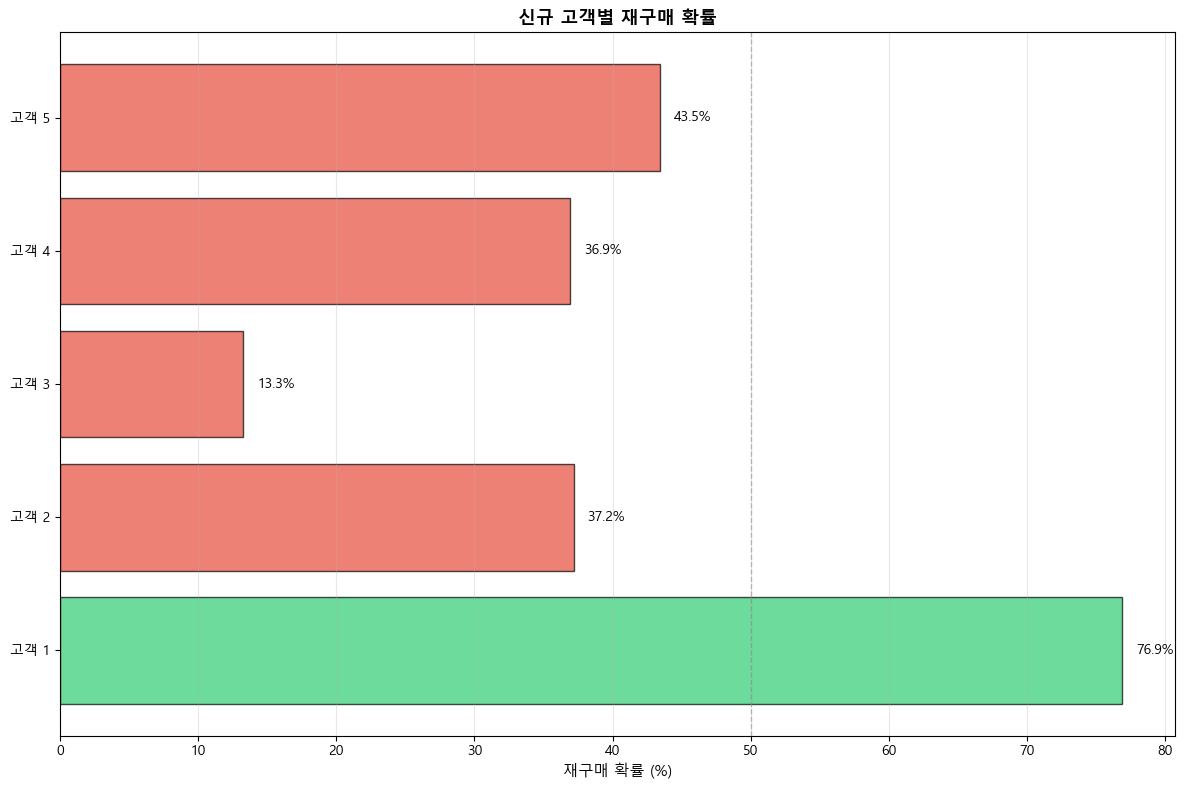

In [22]:
print("\n" + "="*60)
print("전처리 및 재구매 예측")
print("="*60)

# 범주형 변수 인코딩
new_customers_encoded = new_customers.copy()

for col in loaded_encoders.keys():
    if col in new_customers_encoded.columns:
        new_customers_encoded[col] = new_customers_encoded[col].astype(str)
        
        # Unknown 값 처리 (학습 시 보지 못한 값)
        for idx, val in enumerate(new_customers_encoded[col]):
            if val not in loaded_encoders[col].classes_:
                print(f"  ⚠️ Unknown 값 발견: {col} = {val} → 기본값으로 대체")
                new_customers_encoded.loc[idx, col] = loaded_encoders[col].classes_[0]
        
        new_customers_encoded[col] = loaded_encoders[col].transform(new_customers_encoded[col])

print("✅ 범주형 변수 인코딩 완료")

# 스케일링
new_customers_scaled = loaded_scaler.transform(new_customers_encoded)
print("✅ 스케일링 완료")

# 예측
predictions = loaded_model.predict(new_customers_scaled)
predictions_proba = loaded_model.predict_proba(new_customers_scaled)

print("\n" + "="*60)
print("예측 결과")
print("="*60)

results = pd.DataFrame({
    '고객ID': [f'고객_{i+1}' for i in range(len(new_customers))],
    '나이': new_customers['age'].values,
    '첫구매금액': new_customers['first_purchase_price'].values,
    '제품타입': new_customers['first_product_type'].values,
    '재구매예측': ['✅ 재구매' if p == 1 else '❌ 일회성' for p in predictions],
    '재구매확률': [f'{prob[1]*100:.1f}%' for prob in predictions_proba],
    '일회성확률': [f'{prob[0]*100:.1f}%' for prob in predictions_proba]
})

display(results)

# 예측 결과 시각화
plt.figure(figsize=(12, 8))

colors = ['#2ecc71' if p == 1 else '#e74c3c' for p in predictions]
probas = [prob[1]*100 for prob in predictions_proba]

bars = plt.barh(range(len(results)), probas, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(results)), [f"고객 {i+1}" for i in range(len(results))])
plt.xlabel('재구매 확률 (%)', fontsize=11)
plt.title('신규 고객별 재구매 확률', fontsize=13, fontweight='bold')
plt.axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3, axis='x')

# 확률 값 표시
for i, (bar, proba) in enumerate(zip(bars, probas)):
    plt.text(proba + 1, i, f'{proba:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### SHAP을 이용한 개별 고객 예측 설명


SHAP 개별 고객 분석 (고객 1~2)
✅ SHAP 값 계산 완료 (기준값: -0.0094)

고객 1: 28세, Trousers, 3월 구매
재구매 확률: 76.9%


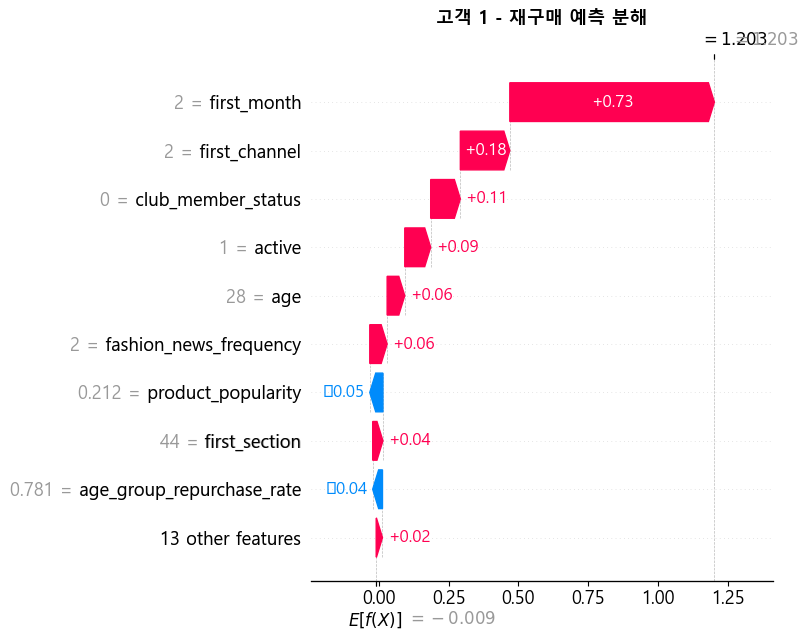


[주요 기여 특성 Top 3]
  1. first_month: +0.7331 (재구매↑)
  2. first_channel: +0.1773 (재구매↑)
  3. club_member_status: +0.1062 (재구매↑)

고객 2: 45세, Bikini top, 8월 구매
재구매 확률: 37.2%


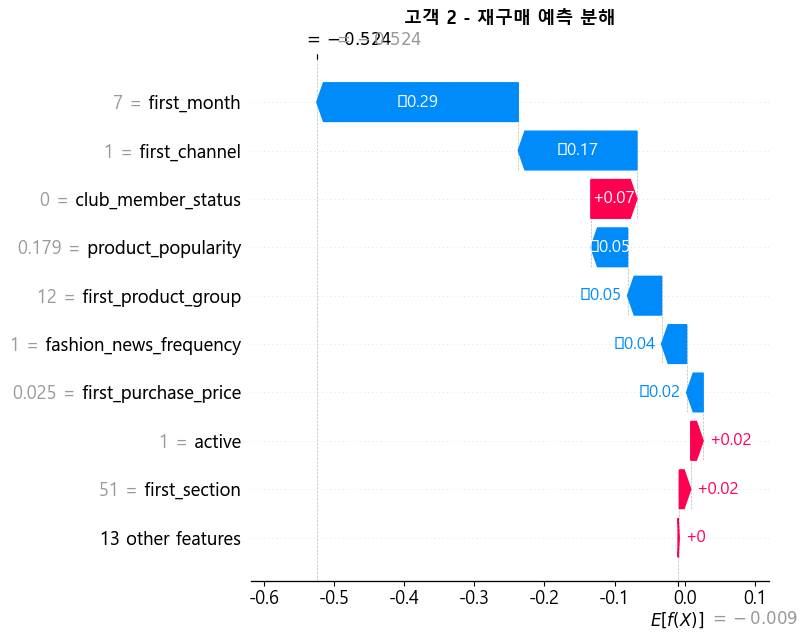


[주요 기여 특성 Top 3]
  1. first_month: -0.2872 (재구매↓)
  2. first_channel: -0.1692 (재구매↓)
  3. club_member_status: +0.0657 (재구매↑)


📊 해석:
- 기준값(E[f(x)])에서 시작해 각 특성이 예측을 변화시킴
- 빨강 화살표: 재구매 가능성 증가
- 파랑 화살표: 재구매 가능성 감소
- 모든 기여도를 합하면 최종 예측값



In [23]:
import shap

print("\n" + "="*60)
print("SHAP 개별 고객 분석 (고객 1~2)")
print("="*60)

# SHAP Explainer 생성
explainer = shap.TreeExplainer(loaded_model)
shap_values_new = explainer.shap_values(new_customers_scaled)
base_value = explainer.expected_value

print(f"✅ SHAP 값 계산 완료 (기준값: {base_value:.4f})")

# 고객 1, 2만 분석
for i in range(2):
    print(f"\n{'='*60}")
    print(f"고객 {i+1}: {new_customers.iloc[i]['age']:.0f}세, "
          f"{new_customers.iloc[i]['first_product_type']}, "
          f"{new_customers.iloc[i]['first_month']+1}월 구매")
    print(f"재구매 확률: {predictions_proba[i][1]*100:.1f}%")
    print(f"{'='*60}")
    
    # Waterfall Plot
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_new[i],
            base_values=base_value,
            data=new_customers_encoded.iloc[i],
            feature_names=new_customers_encoded.columns.tolist()
        ),
        max_display=10,
        show=False
    )
    plt.title(f'고객 {i+1} - 재구매 예측 분해', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 주요 기여 특성 Top 3
    feature_names = new_customers_encoded.columns.tolist()
    shap_abs = np.abs(shap_values_new[i])
    top3_idx = np.argsort(shap_abs)[-3:][::-1]
    
    print("\n[주요 기여 특성 Top 3]")
    for rank, idx in enumerate(top3_idx, 1):
        feat_name = feature_names[idx]
        shap_val = shap_values_new[i][idx]
        direction = "재구매↑" if shap_val > 0 else "재구매↓"
        print(f"  {rank}. {feat_name}: {shap_val:+.4f} ({direction})")

print("""
\n📊 해석:
- 기준값(E[f(x)])에서 시작해 각 특성이 예측을 변화시킴
- 빨강 화살표: 재구매 가능성 증가
- 파랑 화살표: 재구매 가능성 감소
- 모든 기여도를 합하면 최종 예측값
""")

# [참고] 앙상블 모델 구축을 통한 성능 최적화

### 앙상블 방법 비교

**Hard Voting:**
- 각 모델이 예측한 클래스를 다수결로 결정
- 예: LR(재구매), RF(재구매), XGBoost(일회성) → 최종: 재구매 예측

**Soft Voting:**
- 각 모델의 예측 확률을 평균하여 결정
- 예: LR(0.7), RF(0.6), XGBoost(0.4) → 평균: 0.57 → 재구매 예측

**Stacking:**
- **1단계**: Base 모델들이 학습 데이터로 예측값 생성 (교차검증 사용)
- **2단계**: 이 예측값들을 새로운 특성(feature)으로 사용
- **3단계**: Meta 모델이 Base 모델들의 예측을 입력받아 최종 예측 학습
- 예: LR, RF, XGBoost 예측 → [0.7, 0.6, 0.4] → Meta 모델(Logistic) → 최종: 재구매 예측
- 가장 복잡하지만 성능이 가장 좋을 가능성 높음


앙상블 모델 - Voting & Stacking

[Voting Ensemble 구축]
Base Models: LR, RF, XGBoost, Naive Bayes

[Hard Voting] 학습 중...
✅ 완료!
Accuracy:  0.6521
Precision: 0.6435
Recall:    0.6755
F1-Score:  0.6591

------------------------------------------------------------
[Soft Voting] 학습 중...
✅ 완료!
Accuracy:  0.6478
Precision: 0.6262
Recall:    0.7261
F1-Score:  0.6725
ROC-AUC:   0.7033


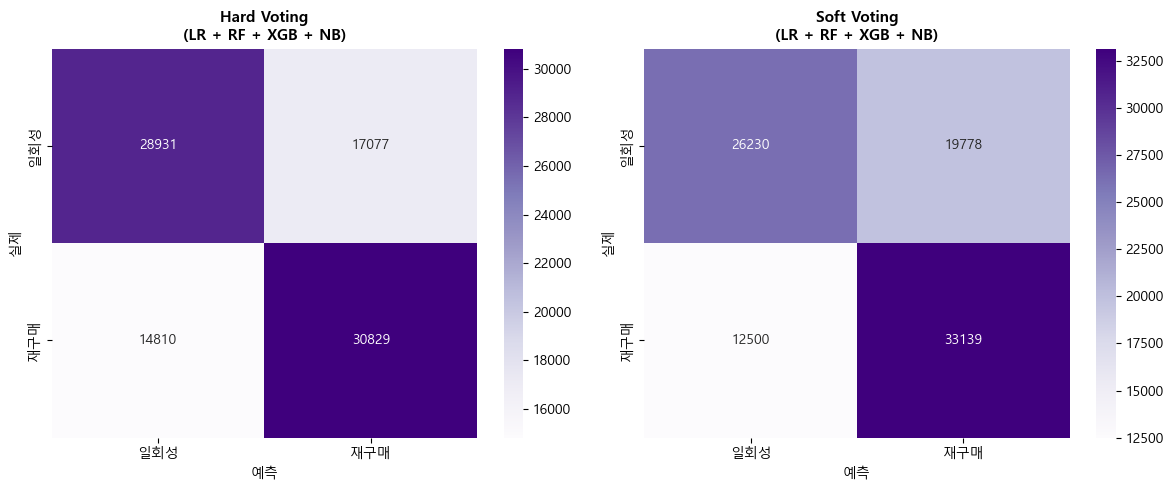


Stacking Ensemble

[구조]
Base Models:
  • Logistic Regression (선형)
  • Random Forest (배깅)
  • XGBoost (부스팅)
  • Naive Bayes (확률)

Meta Model:
  • Logistic Regression

학습 중... (CV=5, 시간 소요)
✅ 완료!

[Stacking 성능]
Accuracy:  0.6549
Precision: 0.6419
Recall:    0.6943
F1-Score:  0.6671
ROC-AUC:   0.7107


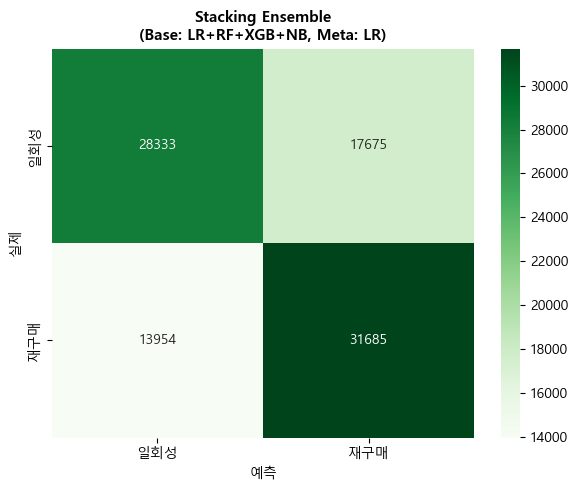


전체 모델 성능 비교

[모델별 성능 지표]


,모델,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.6448,0.6359,0.6711,0.6530,0.6963
1,Random Forest,0.6243,0.6216,0.6279,0.6247,0.6704
2,XGBoost,0.6548,0.6403,0.7002,0.6689,0.7106
3,Voting (Hard),0.6521,0.6435,0.6755,0.6591,NaN
4,Voting (Soft),0.6478,0.6262,0.7261,0.6725,0.7033
5,Stacking,0.6549,0.6419,0.6943,0.6671,0.7107



🏆 최고 Accuracy: Stacking (0.6549)
🏆 최고 ROC-AUC: Stacking (0.7107)


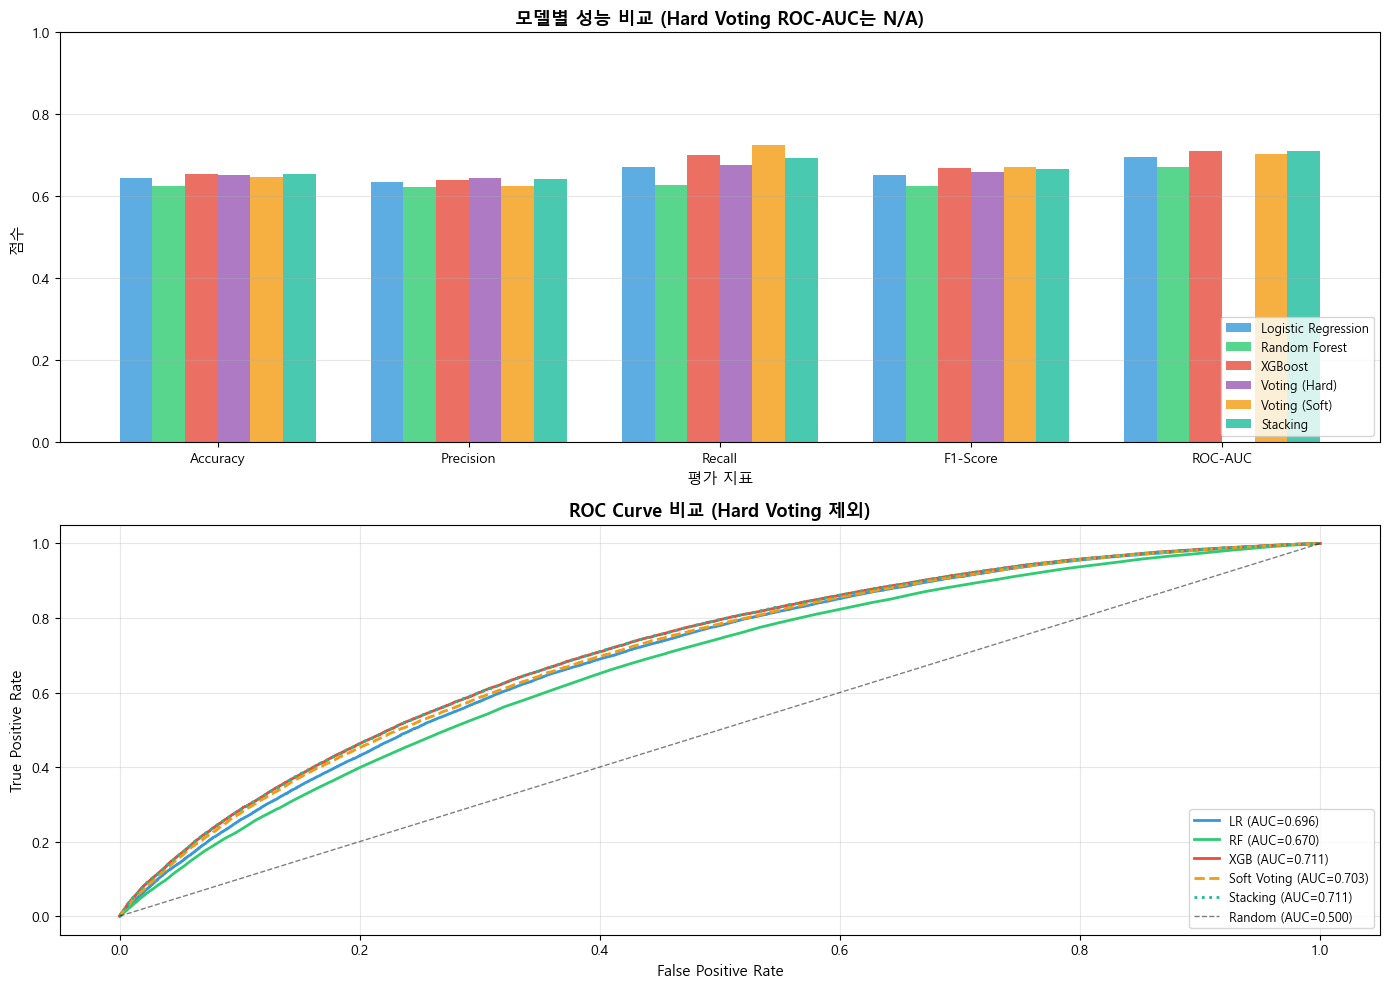


앙상블 효과 분석

개별 모델 평균 Accuracy: 0.6413
앙상블 모델 평균 Accuracy: 0.6516
성능 향상: 1.03%p

최고 개별 모델: XGBoost
  Accuracy: 0.6548

최고 앙상블 모델: Stacking
  Accuracy: 0.6549

✅ 앙상블 모델링 완료!


In [ ]:
# ============================================================
# 앙상블 모델 구축
# 
# 사용 모델:
# - Logistic Regression (선형 모델)
# - Random Forest (배깅 앙상블)
# - XGBoost (부스팅 앙상블)
# - Naive Bayes (확률 기반)
# ============================================================

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB

print("\n" + "="*60)
print("앙상블 모델 - Voting & Stacking")
print("="*60)

# ============================================================
# 1. Voting Ensemble
# ============================================================

print("\n[Voting Ensemble 구축]")
print("Base Models: LR, RF, XGBoost, Naive Bayes")

# ----- Hard Voting (다수결 투표) -----
voting_hard = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, 
                                  max_depth=5, random_state=42, eval_metric='logloss')),
        ('nb', GaussianNB())  
    ],
    voting='hard'  # 각 모델의 예측 클래스를 투표
)

print("\n[Hard Voting] 학습 중...")
voting_hard.fit(X_train_scaled, y_train)
y_pred_hard = voting_hard.predict(X_test_scaled)

print(f"✅ 완료!")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_hard):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_hard):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_hard):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_hard):.4f}")

# ----- Soft Voting (확률 평균) -----
print("\n" + "-"*60)
voting_soft = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, 
                                  max_depth=5, random_state=42, eval_metric='logloss')),
        ('nb', GaussianNB())
    ],
    voting='soft'  # 각 모델의 예측 확률을 평균
)

print("[Soft Voting] 학습 중...")
voting_soft.fit(X_train_scaled, y_train)
y_pred_soft = voting_soft.predict(X_test_scaled)
y_pred_proba_soft = voting_soft.predict_proba(X_test_scaled)[:, 1]

print(f"✅ 완료!")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_soft):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_soft):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_soft):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_soft):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_soft):.4f}")

# Confusion Matrix 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_hard = confusion_matrix(y_test, y_pred_hard)
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['일회성', '재구매'], 
            yticklabels=['일회성', '재구매'])
axes[0].set_title('Hard Voting\n(LR + RF + XGB + NB)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('실제')
axes[0].set_xlabel('예측')

cm_soft = confusion_matrix(y_test, y_pred_soft)
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['일회성', '재구매'], 
            yticklabels=['일회성', '재구매'])
axes[1].set_title('Soft Voting\n(LR + RF + XGB + NB)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('실제')
axes[1].set_xlabel('예측')

plt.tight_layout()
plt.show()

# ============================================================
# 2. Stacking Ensemble
# ============================================================

print("\n" + "="*60)
print("Stacking Ensemble")
print("="*60)

# Base 모델들의 예측을 Meta 모델이 학습
stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, 
                                  max_depth=5, random_state=42, eval_metric='logloss')),
        ('nb', GaussianNB())  # Naive Bayes 추가
    ],
    final_estimator=LogisticRegression(random_state=42),  # Meta 모델
    cv=5,  # 5-Fold Cross Validation
    n_jobs=-1
)

print("\n[구조]")
print("Base Models:")
print("  • Logistic Regression (선형)")
print("  • Random Forest (배깅)")
print("  • XGBoost (부스팅)")
print("  • Naive Bayes (확률)")
print("\nMeta Model:")
print("  • Logistic Regression")

print("\n학습 중... (CV=5, 시간 소요)")
stacking_model.fit(X_train_scaled, y_train)
print("✅ 완료!")

# 예측 및 평가
y_pred_stacking = stacking_model.predict(X_test_scaled)
y_pred_proba_stacking = stacking_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n[Stacking 성능]")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_stacking):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_stacking):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_stacking):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_stacking):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_stacking):.4f}")

# Confusion Matrix
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['일회성', '재구매'], 
            yticklabels=['일회성', '재구매'])
plt.title('Stacking Ensemble\n(Base: LR+RF+XGB+NB, Meta: LR)', 
          fontsize=11, fontweight='bold')
plt.ylabel('실제')
plt.xlabel('예측')
plt.tight_layout()
plt.show()

# ============================================================
# 3. 전체 모델 성능 비교
# ============================================================

print("\n" + "="*60)
print("전체 모델 성능 비교")
print("="*60)

# 성능 지표 DataFrame 생성
results_df = pd.DataFrame({
    '모델': ['Logistic Regression', 'Random Forest', 'XGBoost', 
            'Voting (Hard)', 'Voting (Soft)', 'Stacking'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_hard),
        accuracy_score(y_test, y_pred_soft),
        accuracy_score(y_test, y_pred_stacking)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_hard),
        precision_score(y_test, y_pred_soft),
        precision_score(y_test, y_pred_stacking)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_hard),
        recall_score(y_test, y_pred_soft),
        recall_score(y_test, y_pred_stacking)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_hard),
        f1_score(y_test, y_pred_soft),
        f1_score(y_test, y_pred_stacking)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb),
        np.nan,  # Hard Voting은 확률 예측 불가
        roc_auc_score(y_test, y_pred_proba_soft),
        roc_auc_score(y_test, y_pred_proba_stacking)
    ]
})

print("\n[모델별 성능 지표]")
display(results_df.round(4))

# 최고 성능 모델 표시 (Accuracy 기준)
best_acc_idx = results_df['Accuracy'].idxmax()
best_auc_idx = results_df['ROC-AUC'].idxmax()

print(f"\n최고 Accuracy: {results_df.loc[best_acc_idx, '모델']} ({results_df.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"최고 ROC-AUC: {results_df.loc[best_auc_idx, '모델']} ({results_df.loc[best_auc_idx, 'ROC-AUC']:.4f})")

# ============================================================
# 4. 시각화
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# (1) 지표별 비교 - Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.13

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

for i, (idx, row) in enumerate(results_df.iterrows()):
    values = row[1:].values
    # NaN 값을 0으로 대체 (시각화용)
    values = [v if not np.isnan(v) else 0 for v in values]
    axes[0].bar(x + (i-2.5)*width, values, width, label=row['모델'], 
                alpha=0.8, color=colors[i])

axes[0].set_xlabel('평가 지표', fontsize=11)
axes[0].set_ylabel('점수', fontsize=11)
axes[0].set_title('모델별 성능 비교 (Hard Voting ROC-AUC는 N/A)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

# (2) ROC Curve 비교 (Hard Voting 제외)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_soft, tpr_soft, _ = roc_curve(y_test, y_pred_proba_soft)
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_pred_proba_stacking)

axes[1].plot(fpr_lr, tpr_lr, label=f'LR (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})', 
             linewidth=2, color=colors[0])
axes[1].plot(fpr_rf, tpr_rf, label=f'RF (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})', 
             linewidth=2, color=colors[1])
axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})', 
             linewidth=2, color=colors[2])
axes[1].plot(fpr_soft, tpr_soft, label=f'Soft Voting (AUC={roc_auc_score(y_test, y_pred_proba_soft):.3f})', 
             linewidth=2, color=colors[4], linestyle='--')
axes[1].plot(fpr_stacking, tpr_stacking, label=f'Stacking (AUC={roc_auc_score(y_test, y_pred_proba_stacking):.3f})', 
             linewidth=2, color=colors[5], linestyle=':')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1, alpha=0.5)

axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve 비교 (Hard Voting 제외)', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 5. 앙상블 효과 분석
# ============================================================

print("\n" + "="*60)
print("앙상블 효과 분석")
print("="*60)

# 개별 모델 vs 앙상블 모델 평균 비교 (Accuracy 기준)
base_models_acc = results_df.iloc[:3]['Accuracy'].mean()
ensemble_models_acc = results_df.iloc[3:]['Accuracy'].mean()

print(f"\n개별 모델 평균 Accuracy: {base_models_acc:.4f}")
print(f"앙상블 모델 평균 Accuracy: {ensemble_models_acc:.4f}")
print(f"성능 향상: {(ensemble_models_acc - base_models_acc)*100:.2f}%p")

# 최고 성능 모델 상세 (Accuracy 기준)
print(f"\n최고 개별 모델: {results_df.iloc[:3].loc[results_df.iloc[:3]['Accuracy'].idxmax(), '모델']}")
print(f"  Accuracy: {results_df.iloc[:3]['Accuracy'].max():.4f}")
print(f"\n최고 앙상블 모델: {results_df.iloc[3:].loc[results_df.iloc[3:]['Accuracy'].idxmax(), '모델']}")
print(f"  Accuracy: {results_df.iloc[3:]['Accuracy'].max():.4f}")

print("\n" + "="*60)
print("✅ 앙상블 모델링 완료!")
print("="*60)